# Analyse Weights and Biases Runs

#### Import Libraries

In [1]:
# Import Libraries & Load Data
# !pip install wandb pandas matplotlib seaborn
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Set display options for wide DataFrames
pd.set_option('display.max_columns', 50)

#### Define project names

In [2]:
# Define W&B Project names
projects = [
    "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev",
    "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug",
    "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout",
    "tkshfj-bsc-computer-science-university-of-london/baseline_shallow_cnn"
]

#### Connect to W&B and Download Runs

In [3]:
# Initialize W&B API
api = wandb.Api()

all_runs_hyperparams = []

for project in projects:
    print(f"Fetching runs from: {project}")
    runs = api.runs(project)

    for run in runs:
        if run.state == "finished":
            config = {k: v for k, v in run.config.items() if not k.startswith("_")}
            config['run_id'] = run.id
            config['run_name'] = run.name
            all_runs_hyperparams.append(config)

# Convert to DataFrame
df_all_hyperparams = pd.DataFrame(all_runs_hyperparams)

# Show the result
df_all_hyperparams.head()


Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev
Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug
Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout
Fetching runs from: tkshfj-bsc-computer-science-university-of-london/baseline_shallow_cnn


,zoom,epochs,dropout,filters,rotation,optimizer,batch_size,kernel_size,translation,learning_rate,run_id,run_name,architecture
0,0.118281,20,0.457431,32.0,0.185733,Adam,12,3.0,0.028774,0.000535,robn7eui,pleasant-sweep-1,NaN
1,0.064598,20,0.336429,16.0,0.169841,Adam,12,5.0,0.198497,0.000925,3g59hei1,fresh-sweep-2,NaN
2,0.073080,20,0.302445,16.0,0.168715,Adam,8,5.0,0.029685,0.000899,qecspgb9,vague-sweep-3,NaN
3,0.105956,20,0.453570,16.0,0.005078,Adam,16,3.0,0.179405,0.000526,a55xgzua,peach-sweep-4,NaN
4,0.116883,20,0.352475,16.0,0.093815,Adam,12,3.0,0.098259,0.000551,0tiuh0xt,woven-sweep-5,NaN


In [4]:
df_all_hyperparams.to_csv("all_runs_hyperparams.csv", index=True)

#### Fetch runs from projects

In [5]:
def fetch_runs(project):
    runs = api.runs(project)
    records = []
    for run in runs:
        if run.state == "finished":
            rec = dict(run.summary)
            rec.update(dict(run.config))
            rec["run_id"] = run.id
            rec["run_name"] = run.name
            records.append(rec)
    return pd.DataFrame(records)

#### Try to get predictions and labels from run summary or artifacts

In [6]:
def try_get_preds_labels(run):
    # As summary arrays
    preds = run.summary.get('preds') or run.summary.get('y_pred') or run.summary.get('predictions')
    labels = run.summary.get('labels') or run.summary.get('y_true') or run.summary.get('ground_truth')
    if preds is not None and labels is not None:
        # Convert to np arrays if necessary
        preds = np.array(preds)
        labels = np.array(labels)
        # If predictions are probabilities, convert to binary
        if preds.ndim > 1 and preds.shape[-1] == 2:  # [N, 2]
            preds = np.argmax(preds, axis=1)
        elif preds.ndim == 1 and (preds.max() > 1 or preds.min() < 0):
            preds = (preds > 0.5).astype(int)
        return preds, labels

    # Look for wandb Table artifact
    for artifact in run.logged_artifacts():
        if "confusion" in artifact.name or "eval" in artifact.name or "pred" in artifact.name:
            table = artifact.get("table")
            if table:
                df = table.dataframe()
                pred_col = [c for c in df.columns if "pred" in c][0]
                label_col = [c for c in df.columns if "label" in c][0]
                preds = df[pred_col].values
                labels = df[label_col].values
                return preds, labels
    # Not found
    return None, None

#### Get best run by validation AUC and plot loss and AUC curves

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev
Best run: colorful-sweep-6, val_auc=0.733


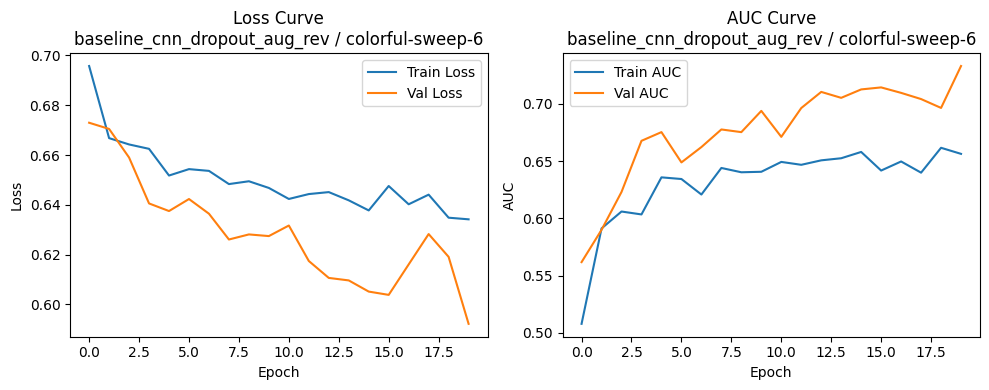

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug
Best run: rural-sweep-1, val_auc=0.730


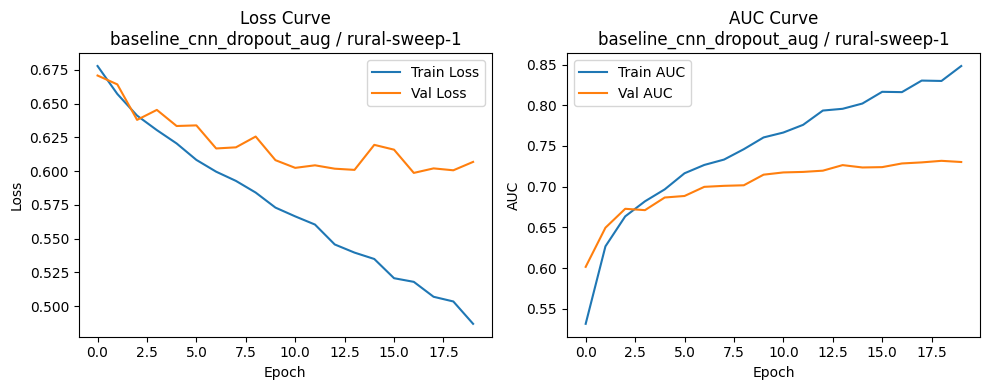

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout
Best run: deep-sweep-3, val_auc=0.749


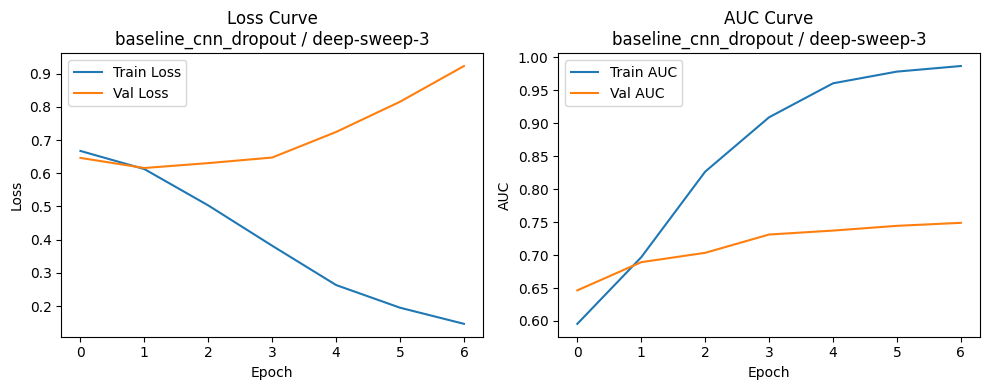

Processing project: tkshfj-bsc-computer-science-university-of-london/baseline_shallow_cnn
Best run: classic-surf-1, val_auc=0.792


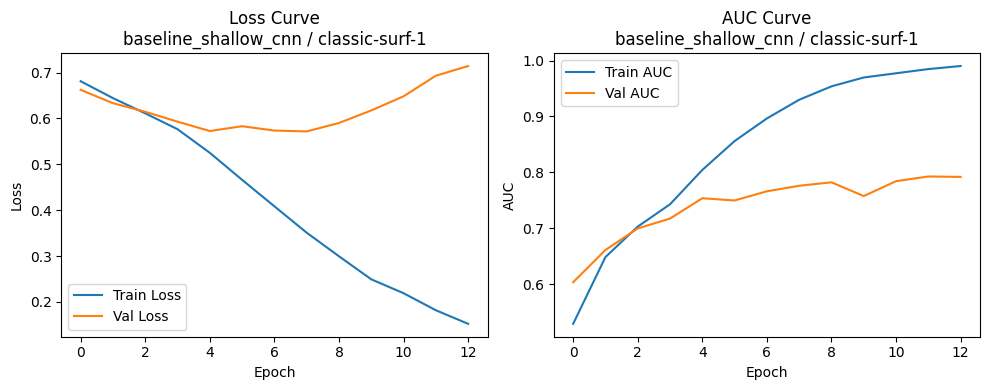

Summary of best runs per project:


,Project,Run Name,val_accuracy,val_auc,val_loss
0,baseline_cnn_dropout_aug_rev,colorful-sweep-6,0.665779,0.733171,0.592204
1,baseline_cnn_dropout_aug,rural-sweep-1,0.683089,0.730330,0.606858
2,baseline_cnn_dropout,deep-sweep-3,0.671105,0.748847,0.922707
3,baseline_shallow_cnn,classic-surf-1,0.728362,0.791855,0.714357


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

summary_table = []

for project in projects:
    print(f"Processing project: {project}")
    df = fetch_runs(project)
    
    if df.empty or 'epoch/val_auc' not in df.columns:
        print(f"No suitable runs found in {project}")
        continue

    # Get best run by validation AUC
    best_run_row = df.sort_values('epoch/val_auc', ascending=False).iloc[0]
    print(f"Best run: {best_run_row['run_name']}, val_auc={best_run_row['epoch/val_auc']:.3f}")

    # Append to summary
    summary_table.append({
        'Project': project.split('/')[-1],
        'Run Name': best_run_row['run_name'],
        'val_accuracy': best_run_row['epoch/val_accuracy'],
        'val_auc': best_run_row.get('epoch/val_auc', None),
        'val_loss': best_run_row.get('epoch/val_loss', None)
    })

    # Plot curves for best run
    run = api.run(f"{project}/{best_run_row['run_id']}")
    history = run.history(keys=[
        "epoch/epoch", "epoch/loss", "epoch/val_loss", "epoch/auc", "epoch/val_auc"
    ])

    epochs = history["epoch/epoch"]

    # Side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss Curve
    axes[0].plot(epochs, history["epoch/loss"], label="Train Loss")
    axes[0].plot(epochs, history["epoch/val_loss"], label="Val Loss")
    axes[0].set_title(f"Loss Curve\n{project.split('/')[-1]} / {best_run_row['run_name']}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # AUC Curve
    axes[1].plot(epochs, history["epoch/auc"], label="Train AUC")
    axes[1].plot(epochs, history["epoch/val_auc"], label="Val AUC")
    axes[1].set_title(f"AUC Curve\n{project.split('/')[-1]} / {best_run_row['run_name']}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("AUC")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Show summary table
summary_df = pd.DataFrame(summary_table)
print("Summary of best runs per project:")
display(summary_df)


#### Analyzxe the sweep runs for the baseline CNN dropout aug rev project

In [5]:
import wandb
import pandas as pd

api = wandb.Api()

project = "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev"
runs = api.runs(project)

In [13]:
summary_list, config_list, name_list, id_list = [], [], [], []
for run in runs:
    # Each run.summary is a dict with metrics
    summary = dict(run.summary)
    config = {k: v for k, v in run.config.items() if not k.startswith('_')}
    summary_list.append(summary)
    config_list.append(config)
    name_list.append(run.name)
    id_list.append(run.id)

# Combine
summary_df = pd.DataFrame(summary_list)
config_df = pd.DataFrame(config_list)
runs_df = pd.concat([summary_df, config_df], axis=1)
runs_df['run_name'] = name_list
runs_df['run_id'] = id_list

print(runs_df.columns.tolist())

['_runtime', '_step', '_timestamp', '_wandb', 'epoch/accuracy', 'epoch/auc', 'epoch/epoch', 'epoch/learning_rate', 'epoch/loss', 'epoch/precision', 'epoch/recall', 'epoch/val_accuracy', 'epoch/val_auc', 'epoch/val_loss', 'epoch/val_precision', 'epoch/val_recall', 'confusion_matrix', 'val_final_accuracy', 'val_final_auc', 'val_final_loss', 'val_final_precision', 'val_final_recall', 'zoom', 'epochs', 'dropout', 'filters', 'rotation', 'optimizer', 'batch_size', 'kernel_size', 'translation', 'learning_rate', 'run_name', 'run_id']


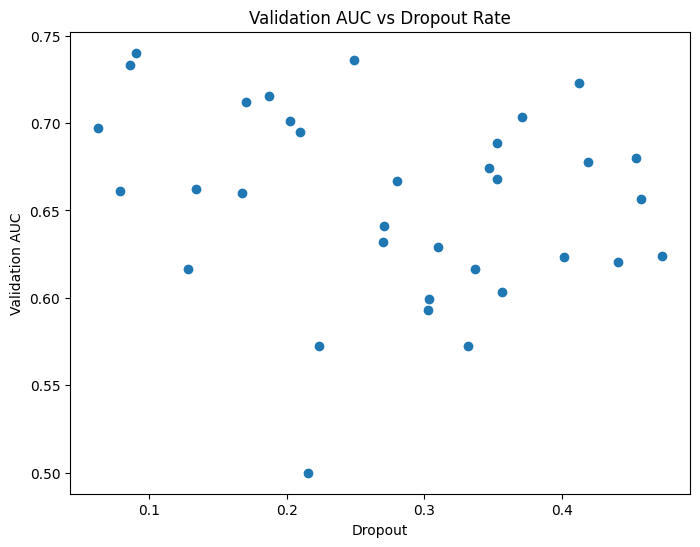

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(runs_df['dropout'], runs_df['epoch/val_auc'])
plt.xlabel('Dropout')
plt.ylabel('Validation AUC')
plt.title('Validation AUC vs Dropout Rate')
plt.show()

In [15]:
best_run = runs[0]  # or runs_df.iloc[0]['run_id'] for more robust indexing

print("Best run name:", best_run.name)
print("Best val_auc:", best_run.summary.get('val_auc'))

# Download and display confusion matrix if available as an image artifact
for file in best_run.files():
    if "confusion_matrix" in file.name:
        file.download(replace=True)
        from PIL import Image
        img = Image.open(file.name)
        img.show()
        break

Best run name: fast-sweep-1
Best val_auc: None


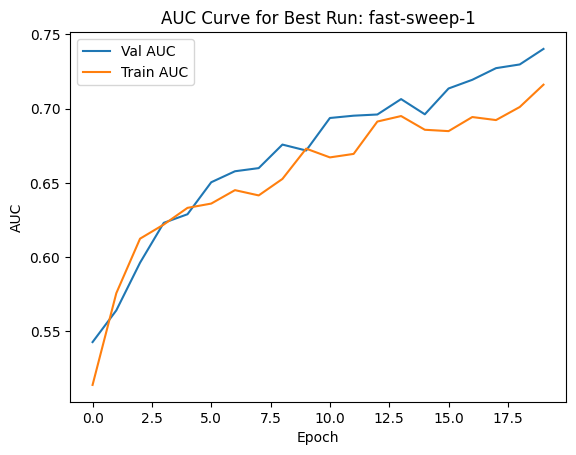

In [18]:
plt.plot(range(len(history)), history['epoch/val_auc'], label='Val AUC')
plt.plot(range(len(history)), history['epoch/auc'], label='Train AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title(f"AUC Curve for Best Run: {best_run.name}")
plt.legend()
plt.show()

In [19]:
for artifact in best_run.logged_artifacts():
    print("Artifact:", artifact.name)
    # Download, load, or further analyze as needed

      run_id            run_name  epoch/val_auc   dropout  epoch/learning_rate
0   0usr1t7n        fast-sweep-1       0.740229  0.090393             0.000719
3   1rr7w9hv        trim-sweep-4       0.736184  0.249003             0.000127
10  gh2bqoh1    colorful-sweep-6       0.733171  0.086059             0.000789
34  8ce210c1  different-sweep-30       0.723070  0.412020             0.000441
17  hr9scxvr  visionary-sweep-13       0.715320  0.186940             0.000435


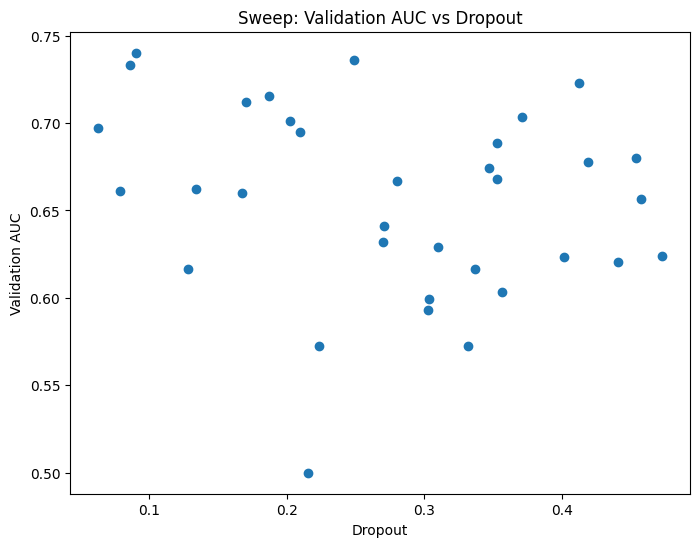

In [23]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

api = wandb.Api()
project = "tkshfj-bsc-computer-science-university-of-london/baseline_cnn_dropout_aug_rev"
runs = api.runs(project)

data = []
for run in runs:
    row = {**run.summary, **{k: v for k, v in run.config.items() if not k.startswith('_')}}
    row['run_id'] = run.id
    row['run_name'] = run.name
    data.append(row)

df = pd.DataFrame(data)
df = df.sort_values('epoch/val_auc', ascending=False)  # Use epoch/val_auc if that's the column

print(df[['run_id', 'run_name', 'epoch/val_auc', 'dropout', 'epoch/learning_rate']].head())

plt.figure(figsize=(8, 6))
plt.scatter(df['dropout'], df['epoch/val_auc'])
plt.xlabel('Dropout')
plt.ylabel('Validation AUC')
plt.title('Sweep: Validation AUC vs Dropout')
plt.show()

In the sweep, the best validation AUC (0.74) was achieved with a dropout rate of 0.09 and a learning rate of 0.0007. There was no substantial benefit from higher dropout, and all top models clustered near 0.71–0.74 AUC, suggesting either underfitting or that the current model/hyperparameter space is not the major limiting factor. Further experiments could reduce dropout, adjust model depth, or try other regularization strategies.

In [25]:
runs_df

,_runtime,_step,_timestamp,_wandb,epoch/accuracy,epoch/auc,epoch/epoch,epoch/learning_rate,epoch/loss,epoch/precision,...,dropout,filters,rotation,optimizer,batch_size,kernel_size,translation,learning_rate,run_name,run_id
0,4545.143008,19.0,1.749983e+09,{'runtime': 4545},0.659667,0.716141,19.0,0.000719,0.600029,0.597638,...,0.090393,16,0.042940,Adam,32,3,0.045711,0.000719,fast-sweep-1,0usr1t7n
1,4459.599800,19.0,1.749987e+09,{'runtime': 4459},0.639667,0.681208,19.0,0.000625,0.625417,0.591499,...,0.170461,16,0.158200,Adam,32,5,0.031355,0.000625,smart-sweep-2,0r4uhkj6
2,NaN,NaN,NaN,{'runtime': 194},NaN,NaN,NaN,NaN,NaN,NaN,...,0.290576,64,0.125972,Adam,8,3,0.096299,0.000782,decent-sweep-3,progqbq3
3,4459.439740,19.0,1.749992e+09,{'runtime': 4459},0.669333,0.725675,19.0,0.000127,0.592723,0.618677,...,0.249003,32,0.018069,Adam,32,3,0.052643,0.000127,trim-sweep-4,1rr7w9hv
4,3915.903334,16.0,1.749996e+09,{'runtime': 3915},0.600000,0.634317,16.0,0.000872,0.647792,0.525641,...,0.270914,16,0.009099,Adam,16,3,0.087155,0.000872,eternal-sweep-5,i6r5sy29
5,4721.702307,21.0,1.750025e+09,{'runtime': 4720},0.600000,0.609945,19.0,0.000535,0.659680,0.548387,...,0.457431,32,0.185733,Adam,12,3,0.028774,0.000535,pleasant-sweep-1,robn7eui
6,2752.706883,13.0,1.750028e+09,{'runtime': 2752},0.588667,0.583539,11.0,0.000925,0.668779,0.506024,...,0.336429,16,0.169841,Adam,12,5,0.198497,0.000925,fresh-sweep-2,3g59hei1
7,2094.802321,10.0,1.750030e+09,{'runtime': 2094},0.588000,0.575512,8.0,0.000899,0.671986,0.500000,...,0.302445,16,0.168715,Adam,8,5,0.029685,0.000899,vague-sweep-3,qecspgb9
8,4512.258901,21.0,1.750034e+09,{'runtime': 4511},0.611333,0.656164,19.0,0.000526,0.640002,0.574786,...,0.453570,16,0.005078,Adam,16,3,0.179405,0.000526,peach-sweep-4,a55xgzua
9,4512.576313,21.0,1.750039e+09,{'runtime': 4512},0.611667,0.638652,19.0,0.000551,0.649376,0.558101,...,0.352475,16,0.093815,Adam,12,3,0.098259,0.000551,woven-sweep-5,0tiuh0xt


### **Implications from the Sweep Table**

#### **1. Highest AUC**

* The highest validation AUC observed is \~0.73 (`epoch/auc`).
* Top AUCs (≥0.70) are achieved with dropout between **0.09 and 0.41** and learning rates **\~0.0001–0.0007**.
* The best run (`fast-sweep-1`) has **0.716 AUC** with **0.09 dropout**, **16 filters**, and a **3x3 kernel**.

#### **2. Dropout**

* **Low dropout (0.09–0.25) consistently yields higher AUCs**. As dropout increases beyond 0.3, AUC generally declines, though some exceptions exist.
* Extreme dropout values (>0.4) are rare among top runs, suggesting that **moderate regularization is optimal**.

#### **3. Learning Rate**

* All runs use small learning rates (**\~0.0001–0.0009**).
* No clear monotonic trend, but **the best runs cluster around 0.0001–0.0007**.
* Very small learning rates (e.g., 0.00001) do not yield the best AUC.

#### **4. Filters and Kernel Size**

* The **number of filters is either 16, 32, or 64**.
* Top runs don’t show a clear preference for filter count or kernel size in this small sample, but the **top run has 16 filters and 3x3 kernels**.

#### **5. Batch Size**

* Batch sizes vary (8, 12, 16, 32), with no clear impact on AUC in this summary.

#### **6. Model Struggles to Generalize**

* **Best validation accuracy is 0.66**, with validation AUC at \~0.72. These are both modest.
* **Gap between train and val performance is not visible in this summary**, but typically a higher train accuracy than val indicates overfitting.
* **Many runs plateau at similar metrics**, suggesting model or data limitations (either underfitting or data complexity).

#### **7. Outliers & Incomplete Runs**

* Some runs (e.g., `decent-sweep-3`) are incomplete (many NaN values), likely failed or stopped early.

### **Summary for Report or Oral Explanation**

**The shallow CNN sweep shows that validation AUCs cluster in the 0.65–0.73 range, with the best results (AUC ≈ 0.72) at low to moderate dropout (0.09–0.25) and learning rates between 0.0001–0.0007. Extremely high dropout does not improve validation AUC, and other hyperparameters like filter count and batch size have a weaker effect. The model’s moderate performance and lack of sensitivity to some hyperparameters suggest it may be underfitting or that dataset complexity is a limiting factor. Incomplete runs or outliers are likely due to early stops or errors.**
**Further action:** To improve performance, consider increasing model complexity, tuning data augmentation, or addressing possible data preprocessing issues.
